# Artistic Style Transfer

The idea of artistic style transfer is to apply a style of one image (i.e., brush strokes) to another image (i.e., a  cat picture) while keeping its content (i.e., shapes).

This notebook shows how to do the artistic style transfer step by step.

The code is based on Francois Chollet's Neural Style Transfer notebook code [[1]](#ref2).

In [1]:
import numpy as np
import scipy as sp
import keras
import keras.backend as K
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

Using TensorFlow backend.


## Content (Original) Image

We load the content image [[2]](#ref1), onto which we want to transfer the style of another image.

In [2]:
def show_image(image, figsize=None, show_shape=False):
    if figsize is not None:
        plt.figure(figsize=figsize)
    if show_shape:
        plt.title(image.shape)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show()

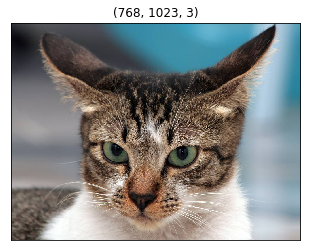

In [3]:
cat_img = plt.imread('../images/cat.835.jpg') # the image source is the reference [4]

show_image(cat_img, show_shape=True)

## Style Image

We load the style image [[3]](#ref3) with which we use to modify the content image.

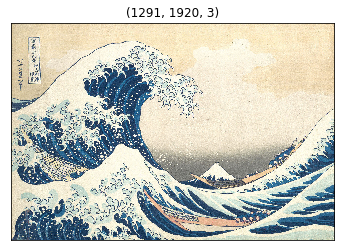

In [4]:
hokusai_img = plt.imread('../images/Tsunami_by_hokusai_19th_century.jpg')      

show_image(hokusai_img, show_shape=True)

The image size of the style image is different from the content image.  As we perform feature by feature comparison, we need to resize the style image to the same as the content image size.

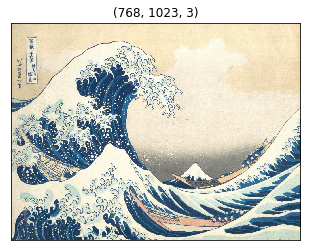

In [5]:
TARGET_SIZE = cat_img.shape[:2]
hokusai_img = sp.misc.imresize(hokusai_img, TARGET_SIZE) # resize the style image to the content image size

show_image(hokusai_img, show_shape=True)

## VGG 16 model and 3 Inputs

We use VGG16 [[4]](#ref4).  It is pre-trained and available in Keras.  We need to prepare input into the format expected by VGG16.

In [6]:
def preprocess(img):
    img = img.copy()                   # copy so that we don't mess the original data
    img = img.astype('float64')        # make sure it's float type
    img = np.expand_dims(img, axis=0)  # change 3-D to 4-D.  the first dimension is the record index
    return keras.applications.vgg16.preprocess_input(img)

We need three inputs:

- the content input has the preprocessed content image data
- the style input has the preprocessed style image data
- the generated input initially has the content image data and will be iteratively updated to apply the style from the style input

In [7]:
def make_inputs(content_img, style_img):
    content_input   = K.constant(preprocess(content_img))
    style_input     = K.constant(preprocess(style_img))
    generated_input = K.placeholder(content_input.shape)  # use the same shape as the content input
    return content_input, style_input, generated_input

We concatenate the three inputs into one input tensor and give to the VGG16 model.

In [8]:
content_input, style_input, generated_input = make_inputs(cat_img, hokusai_img)

input_tensor = K.concatenate([content_input, style_input, generated_input], axis=0)

The `input_tensor`'s shape is (3, height, width, channels or filters).  

- `input_tensor[0]` holds the `content_input`
- `input_tensor[1]` holds the `style_input`
- `input_tensor[2]` holds the `generated_input`

We generate the `generated_input` by manipulating the copy of the content image (i.e., cat image) so that it has the style of the style image (i.e., Hokusai).

The VGG16 model takes the `input_tensor` as input.  The `include_top` is set to `False` as we are only interested in the convolutional layers which are the feature extraction layers.

In [9]:
model = keras.applications.vgg16.VGG16(input_tensor=input_tensor, include_top=False)

We are ready to feed forward these three inputs in VGG16, and then compare generated feature values by using multiple cost functions so that we can adjust the generated image input to apply the style while keeping the content intact.

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

## Content Loss Function

We pick one of the higher layers for the representation of the content of the image such as shapes.  We want to keep the generated image close to the content image.  In other words, we want the generated image to have the same content (i.e., shapes) as the original image.  

As such, we define a cost function to keep the content similarity between the content image and the generated image.  The content cost is the sum of squared differences between the generated features and the content features.

In [11]:
def calc_content_loss(layer_dict, content_layer_names):
    loss = 0
    for name in content_layer_names:
        layer = layer_dict[name]
        content_features   = layer.output[0, :, :, :]  # content features
        generated_features = layer.output[2, :, :, :]  # generated features
        loss += K.sum(K.square(generated_features - content_features)) # keep the similarity between them
    return loss / len(content_layer_names)

In [12]:
layer_dict = {layer.name:layer for layer in model.layers}

# use 'block5_conv2' as the representation of the content image
content_loss = calc_content_loss(layer_dict, ['block5_conv2'])

## Style Loss Function

### Gram Matrix

This is the most difficult part of style transfer.  To define the style loss function, we use the Gram matrix which may not be so intuitive for everyone (not to me anyhow).

Suppose a matrix $C$ contains $n$ column vectors $\hat{c_1}, \hat{c_2}, ...,\hat{c_{n}}$, the Gram matrix of $C$ is $C^TC$ which is a $n \times n$ matrix.  A Gram matrix tells us how column vectors are related to each other.  Say , if two vectors has positive dot product, they are pointing to the similar direction.  If the dot product is zero, they are orthogonal.  If it is negative, they point to opposite directions.  

We use the Gram matrix to see how each filter within a layer relate to each other.

For example, the **block1_conv1** layer has 64 filters.  We flatten all 64 filters (matrices) into 64 vectors: $\hat{v_1}, \hat{v_2}, ...,\hat{v_{64}}$.  Then, we calculate the dot products of every combination of the vectors.  Each of the dot product tells us how strongly the filter combination (i.e., their activations) is related.  This produces a Gram matrix of size 64 by 64.  

In [13]:
def gram_matrix(x):    
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1))) # flatten per filter
    gram = K.dot(features, K.transpose(features)) # calculate the correlation between filters
    return gram

When a style image goes through VGG16 convolutional layers, each layer produces a list of feature matrices.  For example, the **block1_conv1** produces 64 matrices, each of which is a feature matrix produced by applying a convolution operation on the input image.  The same goes for the generated image.

In short, each layer contains a list of feature matrices.  For the style image, we say we have style features in each layer, and for the generated image, we have generated features in each layer.  They are nothing but a list of matrices generated as part of activations for each filter in each layer.

When style features and generated features have similar Gram matrices, they have similar styles because the Gram matrices are generated from the flatten vectors of feature matrices.  If they have similar Gram matrices, the filters are having similar relationships in the same layers.

So, we calculate two Gram matrixes for each layer: one for the style features and the other for the generated features and calculate the sum of the sqaured differences (with some denominators to adjust the values).

For example, the **block1_conv1** layer, we calculate one Gram matrix for the style features and another Gram matrix for the generated features.  We calculate the sum of the squared element wise differences between the two Gram matrices  (divided by a denominator which depends on the size of the feature matrices).  This tells us how similar the style features and the generate features are in the **block1_conv1** layer.

In [14]:
def get_style_loss(style_features, generated_features):
    S = gram_matrix(style_features)
    G = gram_matrix(generated_features)
    channels = 3
    size = TARGET_SIZE[0]*TARGET_SIZE[1]
    return K.sum(K.square(S - G)) / (4. * (channels**2) * (size**2))

We choose a list of layers as the representatives of the image style.  Then, for each layer, we calculate the Gram matrices: one for the style filters and one for the generated fitlers.  We add them up to calculate the style loss.

If the style loss is low, the two image has similar style.  

In [15]:
def calc_style_loss(layer_dict, style_layer_names):
    loss = 0
    for name in style_layer_names:
        layer = layer_dict[name]
        style_features     = layer.output[1, :, :, :] # style features
        generated_features = layer.output[2, :, :, :] # generated features
        loss += get_style_loss(style_features, generated_features) 
    return loss / len(style_layer_names)

In [16]:
style_loss = calc_style_loss(
    layer_dict,
    ['block1_conv1',
     'block2_conv1',
     'block3_conv1',
     'block4_conv1', 
     'block5_conv1'])

## Variation Loss Function

We want to make the generated image somewhat smooth, and not jagged.  The variation loss is defined based on the difference between the neighboring pixel values to avoid sudden jumps in pixel values.

In [17]:
def calc_variation_loss(x):
    row_diff = K.square(x[:, :-1, :-1, :] - x[:, 1:,    :-1, :])
    col_diff = K.square(x[:, :-1, :-1, :] - x[:,  :-1, 1:,   :])
    return K.sum(K.pow(row_diff + col_diff, 1.25))

In [18]:
variation_loss = calc_variation_loss(generated_input)

## Nudge the Image

Based on the combination of the three loss values, we calculate the gradients of it as the generated image as input so that we can nudge the image to reduce the overall cost.  As a result, the generated image keeps the content image while applying the style of the style image.

In [19]:
loss = 0.8 * content_loss + \
       1.0 * style_loss   + \
       0.1 * variation_loss
        
grads = K.gradients(loss, generated_input)[0]

calculate = K.function([generated_input], [loss, grads])

generated_data = preprocess(cat_img)

for i in tqdm(range(10)):
    _, grads_value = calculate([generated_data])
    generated_data -= grads_value * 0.001
    

100%|██████████| 10/10 [00:06<00:00,  1.92it/s]


To display the generated image, we need to do the reverse of the preprocessing.

In [20]:
def deprocess(img):
    img = img.copy()                   # copy so that we don't mess the original data
    img = img[0]                       # take the 3-D image from the 4-D record    
    img[:, :, 0] += 103.939            # these are average color intensities used 
    img[:, :, 1] += 116.779            # by VGG16 which are subtracted from 
    img[:, :, 2] += 123.68             # the content image in the preprocessing
    img = img[:, :, ::-1]              # BGR -> RGB
    img = np.clip(img, 0, 255)         # clip the value within the image intensity range
    return img.astype('uint8')         # convert it to uin8 just like a normal image data

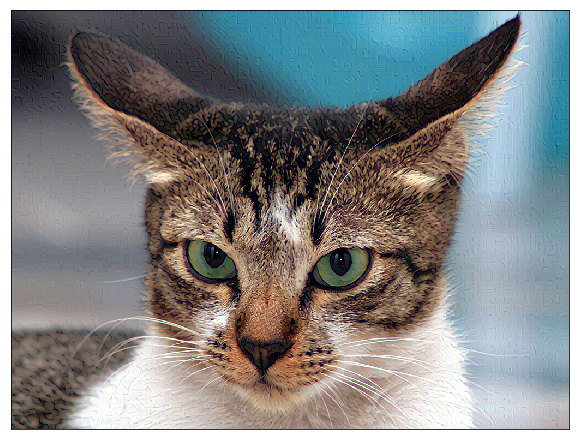

In [21]:
generated_image = deprocess(generated_data)

show_image(generated_image, figsize=(10,20))

The effect is not that obvious here.  We should play with the hyper-parameters.

## Experiments with Hyper-parameters

Let's put all together in one function so that we can do some experiments.

In [22]:
def transfer_style(content_img, 
                   style_img,
                   content_layer_names, 
                   style_layer_names,
                   content_loss_ratio, 
                   style_loss_ratio, 
                   variation_loss_ratio,
                   start_img=None, 
                   steps=10,
                   learning_rate=0.001,
                   show_generated_image=True,
                   figsize=(10,20)):
    # clear the previous session if any
    K.clear_session()
    
    # by default start with the content image
    if start_img is None:
        start_img = content_img

    # prepare inputs and the model
    content_input, style_input, generated_input = make_inputs(content_img, style_img)
    input_tensor = K.concatenate([content_input, style_input, generated_input], axis=0)
    model = keras.applications.vgg16.VGG16(input_tensor=input_tensor, include_top=False)
    
    # calculate various loss
    layer_dict = {layer.name:layer for layer in model.layers}
    content_loss = calc_content_loss(layer_dict, content_layer_names)
    style_loss = calc_style_loss(layer_dict, style_layer_names)
    variation_loss = calc_variation_loss(generated_input)
    
    # calculate the gradients
    loss = content_loss_ratio   * content_loss   + \
           style_loss_ratio     * style_loss     + \
           variation_loss_ratio * variation_loss

    grads = K.gradients(loss, generated_input)[0]
    calculate = K.function([generated_input], [loss, grads])

    # nudge the generated image to apply the style while keeping the content
    generated_data = preprocess(start_img)
    for i in tqdm(range(steps)):
        _, grads_value = calculate([generated_data])
        generated_data -= grads_value * learning_rate
        
    # reverse the preprocessing
    generated_img = deprocess(generated_data)
    
    if show_generated_image:
        show_image(generated_img, figsize=(10,20))
        
    return generated_img

### Only the Style Cost

Let's use only the style cost function.

100%|██████████| 100/100 [00:42<00:00,  2.40it/s]


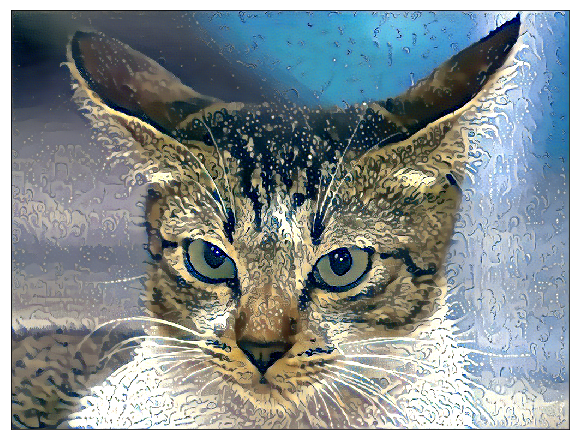

In [23]:
transfer_style(
    cat_img, 
    hokusai_img,
    ['block5_conv2'], 
    ['block1_conv1',
     'block2_conv1',
     'block3_conv1',
     'block4_conv1', 
     'block5_conv1'],
    content_loss_ratio=0.0, 
    style_loss_ratio=1.0, 
    variation_loss_ratio=0.0,
    steps=100,
    learning_rate=0.01);

Does the cat look like completely soaked? Or behind a wet glass window?  Something waterly for sure.

## Adding the Content Loss 

A bit too much of melting look?  Let's add the content loss to avoid deformation.

100%|██████████| 100/100 [00:42<00:00,  2.39it/s]


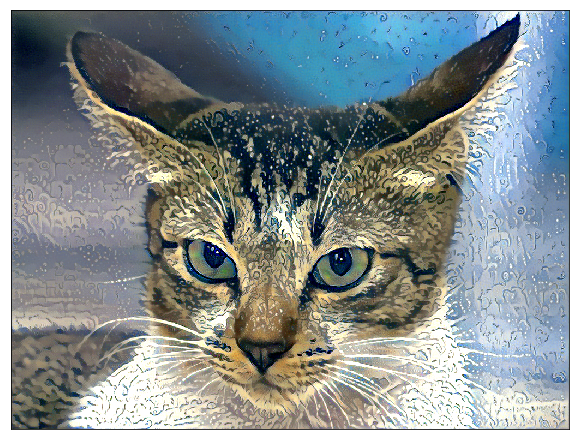

In [24]:
transfer_style(
    cat_img, 
    hokusai_img,
    ['block5_conv2'], 
    ['block1_conv1',
     'block2_conv1',
     'block3_conv1',
     'block4_conv1', 
     'block5_conv1'],
    content_loss_ratio=1.0, 
    style_loss_ratio=1.0, 
    variation_loss_ratio=0.0,
    steps=100,
    learning_rate=0.01);

## Adding the Variation Loss

Let's add variation loss as well to make the image smooth like a paint drawing.

100%|██████████| 100/100 [00:42<00:00,  2.38it/s]


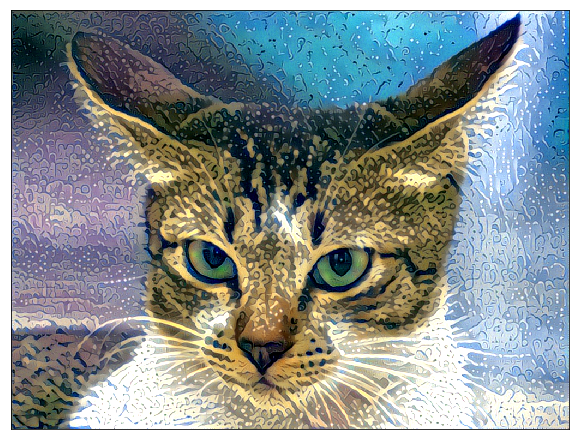

In [25]:
transfer_style(
    cat_img, 
    hokusai_img,
    ['block5_conv2'], 
    ['block1_conv1',
     'block2_conv1',
     'block3_conv1',
     'block4_conv1', 
     'block5_conv1'],
    content_loss_ratio=1.0, 
    style_loss_ratio=1.0, 
    variation_loss_ratio=0.7,               
    steps=100,
    learning_rate=0.01);

It is hard to predict how the generated image looks like before running the experiments.  If you play with the hyper-parameters, be careful not to make them too big which may make the pixel values too small and make the picture completely black.

## How about Dancing Men Style?

In case you are wondering, I drew this image for my soundcloud music ["Hey Man!"](https://soundcloud.com/evergizmo/hey-man).  Let's use it as the style image.

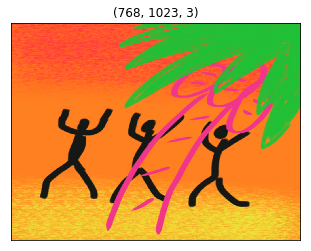

In [26]:
dancing_men_img = plt.imread('../images/dancing_men.png')      

dancing_men_img = sp.misc.imresize(dancing_men_img, TARGET_SIZE)

show_image(dancing_men_img, show_shape=True)

I chose the lower layers as the style thinking that the color and texture will be captured there.  I adjusted other parameters so that it will not go completely black.

100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


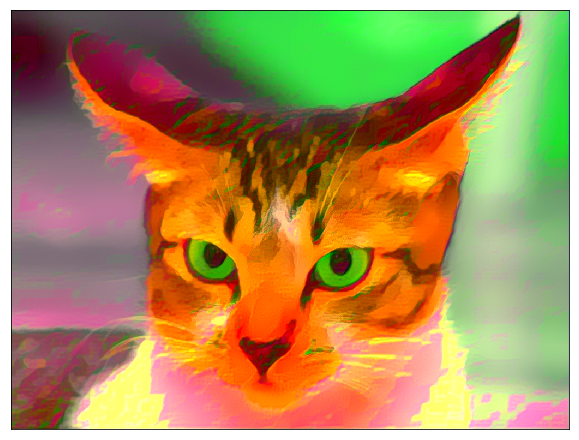

In [27]:
transfer_style(
    cat_img, 
    dancing_men_img,
    ['block5_conv1'], 
    ['block1_conv2',
     'block2_conv2',
     'block3_conv3'],
    content_loss_ratio=0.1, 
    style_loss_ratio=1.0, 
    variation_loss_ratio=0.1,
    steps=100,
    learning_rate=0.001);

The cat looks angrier.  Well, it wasn't as interesting as I was hoping.  I guess the choice of the style image is quite important.

## Start with Noise Image

Another experiment: instead of starting with the content image, let's start with a noise image.  

It will take a longer time before seeing any shape from the content image but the end result is quite interesting.  

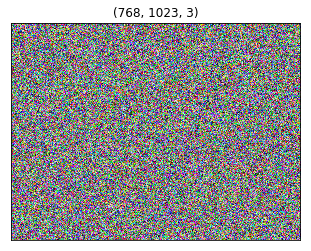

In [28]:
random_img = np.random.uniform(0, 255, cat_img.shape)

show_image(random_img, show_shape=True)

100%|██████████| 5000/5000 [35:34<00:00,  2.37it/s]


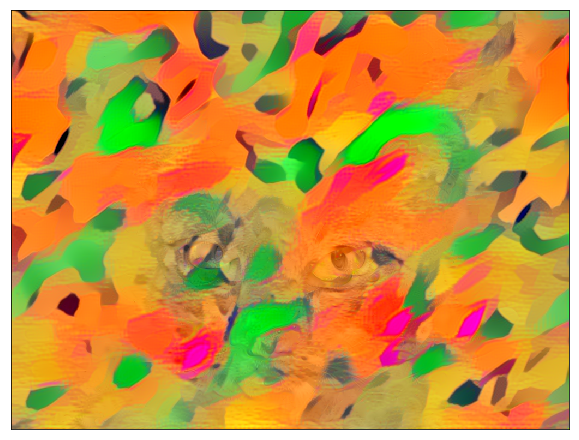

In [29]:
transfer_style(
    cat_img, 
    dancing_men_img,
    ['block5_conv3'], 
    ['block1_conv2',
     'block2_conv2',
     'block3_conv3',
     'block4_conv3', 
     'block5_conv3'],
    content_loss_ratio=1.0, 
    style_loss_ratio=0.05, 
    variation_loss_ratio=0.01,
    start_img=random_img,
    steps=5000,
    learning_rate=0.03);

100%|██████████| 5000/5000 [35:11<00:00,  2.37it/s]


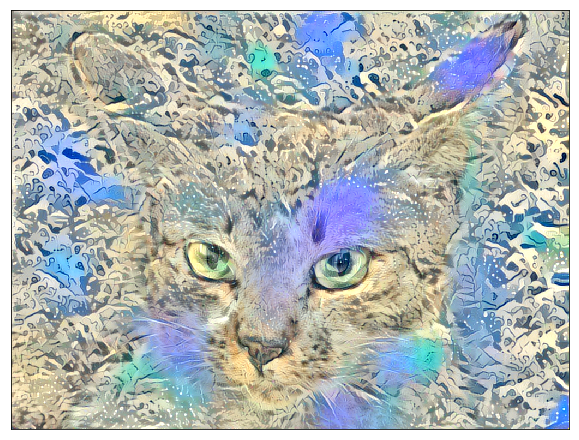

In [30]:
transfer_style(
    cat_img, 
    hokusai_img,
    ['block5_conv2'], 
    ['block1_conv1',
     'block2_conv1',
     'block3_conv1',
     'block4_conv1', 
     'block5_conv1'],
    content_loss_ratio=1.0, 
    style_loss_ratio=0.05, 
    variation_loss_ratio=0.01,
    start_img=random_img,
    steps=5000,
    learning_rate=0.03);

## Reference

<a id="ref1"></a>
### [1] Neural Style Transfer

Francois Chollet

https://github.com/fchollet/keras/blob/master/examples/neural_style_transfer.py


<a id="ref2"></a>
### [2] Dogs vs. Cats Redux: Kernels Edition

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition


<a id="ref3"></a>
### [3] The Great Wave Off Kanagawa

Hokusai Katsushika 

https://en.wikipedia.org/wiki/The_Great_Wave_off_Kanagawa


<a id="ref4"></a>
### [4] Very Deep Convolutional Networks for Large-Scale Image Recognition

Karen Simonyan, Andrew Zisserman

https://arxiv.org/abs/1409.1556


